## Module 11: Kafka & Streaming in Python

We can use Spark (through `pyspark`) to handle streaming data. We do this because Spark is popular and 

1. Fast, fault-tolerant, works with lots of software
2. Can be used with Java, Scala, Python, and R
3. Handles big data
4. Runs machine learning models on big data

Spark SQL DataFrame functions can still be used with streaming to reduce the learning curve.

Spark has at least 2 different interface to handle streaming data. 

1. Spark Streaming (more manual, customizable)
    - uses discretized streams, or `DStreams` (internally is a sequence of RDDs, which are the base object that Spark is using for data)
2. Spark Structured Streaming (much easier to use)
    - can use Spark DataFrames with SQL type functions

### Spark SQL Recap (not pandas-on-spark)

- Use `pyspark.sql.SparkSession` to create a Spark instance. 
- DataFrames are created and implemented on top of RDDs (retrieve metadata about a DataFrame using `df.printSchema()`)
- DataFrames are stored across the cluster on RDDs
    - when _transformations_ are done (e.g. `groupBy()`, `map()`, etc.), lazy evaluation is used (execution does not happen). Common transformations include `.select()` to subset columns, `.withColumn()` to create a new column from another, and `filter()` to subset via a condition. We also have summarizations (often with grouping uses `.groupBy()`) with `.avg()`, `.sum()`, `.count()`, etc.
    - when _actions_ (e.g. `show(n)`, `take(n)`, `collect()`) are done, computation starts and results are returned

Recall that DataFrame and Spark SQL share the same execution engine, so they can be used interchangeably. We can create temporary views using `df.createOrReplaceTempView("df")` and write SQL statements using `spark.sql("SELECT sex, age FROM df LIMIT 4")`.

### Spark Structured Streaming

> Spark Structured Streaming provides fast, scalable, fault-tolerant, end-to-end exactly-once processing without the user having to reason about streaming.


Spark uses micro-batching at time intervals that you set (100 milliseconds minimum). The general process is 

1. Create a Spark session (already available when running `pyspark`)
2. Read in a stream
    - stream from a file, terminal, or use something like Kafka
3. Set up transformations/aggregations to do (mostly using SQL type functions)
    - perhaps over windows
4. Write a query to implement the transformations and define output type
    - console (for debugging)
    - file (such as .csv)
    - database
5. The above won't process data until you `.start()` the query!
6. Continues for as long as specified or until you terminate it

#### Example

Do a basic word count operation using Spark SQL. To prepare the data, we'll use

- `split(str, regex, limit)` - splits `str` around occurrences that match `regex` and returns an array with a length of at most `limit`
- `explore(expr)` - separates the elements of an array `expr` into multiple rows, or the elements of map `expr` into multiple rows and columns

Once the data is prepped, we'll count the occurrences:

- use `.groupBy()` with `.count()`

The syntax will look like `df.select(["Duration", "Age", "Treatment"]).groupBy("Treatment").avg().show()`. We won't be able to use `.show()` because we're dealing with streaming data. 

##### Plan (try this with just Spark, no streaming)

1. Start a Spark session
2. Create a Spark DataFrame from an input data set (strings with words separated by spaces)
3. Split up the strings using `split()` and `explode()`
4. Count the number of times each word appears using `groupBy()` and `count()`
5. Result should be words with their associated counts

See the file `StreamingData_wordCountSparkSQL.ipynb` for an implementation of this example.

#### Example using Streaming Data

To set up a stream, we need a streaming source. One such source is Kafka, which can stream data using producers. The steps are

1. Start up Zookeeper
2. Start Kafka
3. Create a Kafka topic
4. Create a Kafka producer

Next, we follow these steps:

1. Start pyspark
2. Read in the Kafka stream (`.readStream`)
3. Process it to count words (`split()` and `explode()` with `groupBy()` and `count()`)
4. Write the output to the console (`.writeStream`)
5. Start the query and begin sending data

On a Mac M1 (Apple Silicon) you can install Kafka using `brew` with 

`$ brew install kafka`

You can start Zookeeper with 

`$ zookeeper-server-start /opt/homebrew/etc/kafka/zookeeper.properties`

You can then start Kafka with

`$ kafka-server-start /opt/homebrew/etc/kafka/server.properties`

We then need to create a Kafka _topic_ and a Kafka _producer_ that will send out data. The line below creates the topic:

`$ kafka-topics --create -topic mystream --bootstrap-server localhost:9092`

The line below creates the producer:

`$ kafka-console-producer --topic mystream --bootstrap-server localhost:9092`

Then, we can run

`$ pyspark --packages org.apache.spark:spark-sql-kafka-0-10_2.13:3.2.1`

### Reading and writing streams with Spark Structured Streaming

We're going to closely follow the [Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html). 

Recall that the general steps we follow are:

1. Create a Spark session (already available when running `pyspark`)
2. Read in a stream
    - stream from a file, terminal, or use something like Kafka
3. Set up transformations/aggregations to do (mostly using SQL type functions)
    - perhaps over windows
4. Write a query to implement the transformations and define output type
    - console (for debugging)
    - file (such as .csv)
    - database
5. The above won't process data until you `.start()` the query!
6. Continues for as long as specified or until you terminate it

Streaming data frames are slightly different from the Spark SQL DataFrames. 

- Streaming data frames are **unbounded** and the schema is only checked at runtime. Unbounded table means that there is no concrete number of rows - it simply keeps growing. As data comes in, new data in the data streams = new rows appended to an unbounded table.
- Rows are added incrementally

When a query is started, Spark will check for new data at some specified interval (default is 100 milliseconds). If there is new data, Spark will run an "incremental" query that combines the previous running counts with the new data to compute updated counts. 

#### How do we read in a stream?

We can read streaming data using the [`DataStreamReader`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.streaming.DataStreamReader.html) interface (`SparkSession.readStream`). 


* `.readStream` has different methods to customize/set up how to read the stream. 
    - `.format()` - generic, specifies the input source, such as "kafka"
    - `.option(key, value)` - allows an input option on a file source
    - `.load()` - actually load the data into a data stream and return a DataFrame

An example is provided below:

```
df = spark \
.readStream \
.format("kafka") \
.option("subscribe", "mystream") \ # subscribe to a topic called "mystream"
.option("kafka.bootstrap.servers", "localhost:9092") \
.load()
```

For testing purposes, we will also use `rate`. The example below produces data with a time stamp that increments every second.

```
df = spark \
.readStream \
.format("rate") \
.option("rowsPerSecond", 1) \
.load()
```

What if we are not reading from a generic source, but from a source that is more common and structured? We can still use `.option()`, but we will also often use 

- `.schema()` - explicitly specify the schema
- `.csv(path)` - load data from a CSV stream
- `.json(path)` - load data from a JSON file stream
- ... (other types of files)

We do not need to use `.load()` because the two methods above automatically load for us.

As an example of reading from a CSV, we can run

```
# Read all of the CSV files written automatically in a directory

# Specify a schema for the CSV file. We will have a 
# variable called "name" that is a string variable and a
# variable called "age" that is an integer

userSchema = StructType().add("name", "string").add("age", "integer") 

# Read in the data
csvDF = spark \
    .readStream \
    .option("sep", ";") \ # separator is not a comma but a semi-colon
    .schema(userSchema) \ 
    .csv("/path/to/directory")
```

In a terminal, we can run

`$ rateDF = spark.readStream.format("rate").load()`

`$ writeRate = rateDF.writeStream.format("console").outputMode("append").start()`

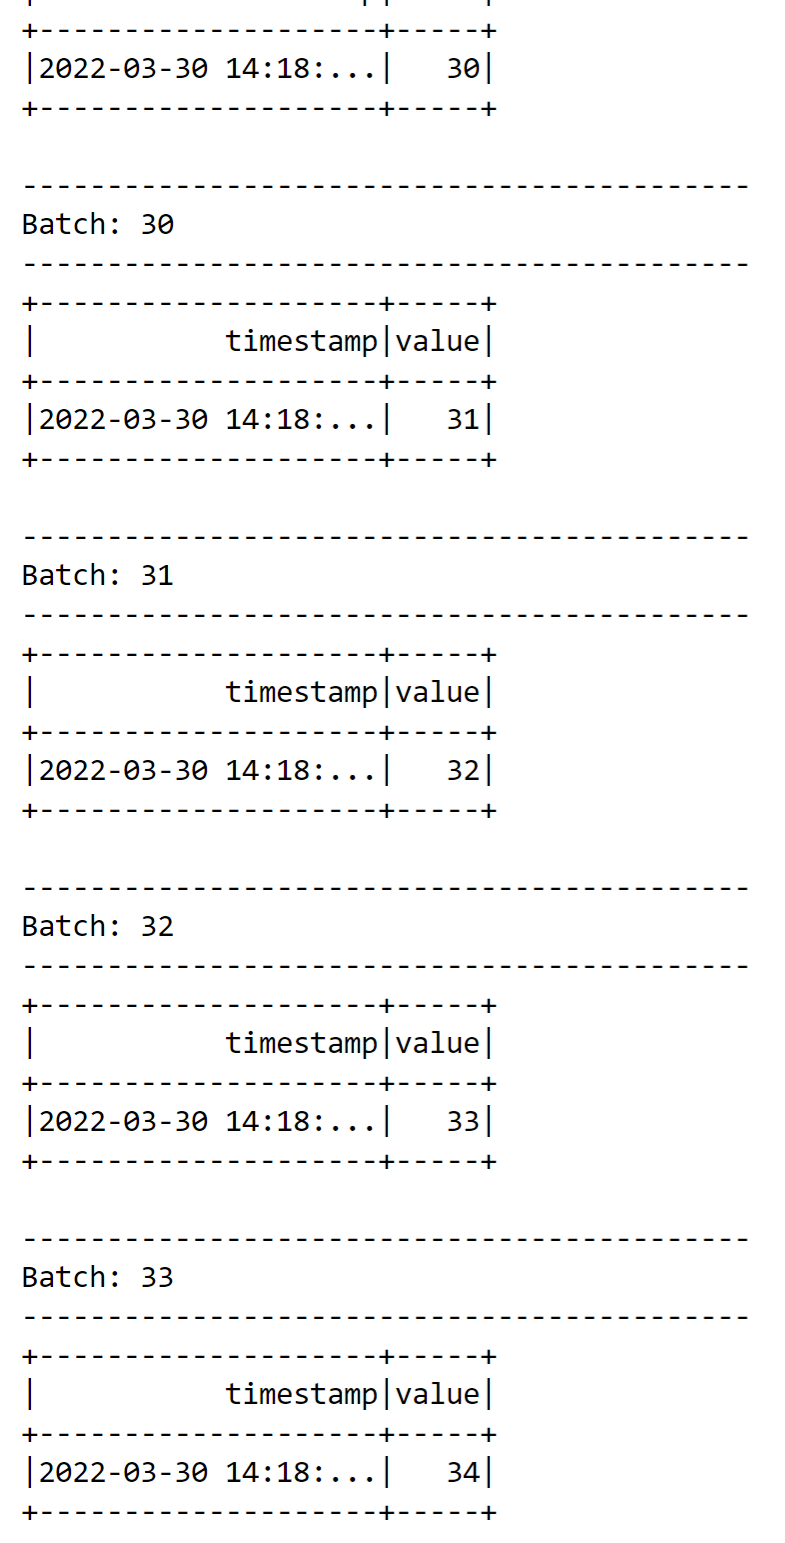

We can stop the stream using `writeRate.stop()`. 

To start our query, we need to specify how we're going to output our information and where we're going to output it. To do this, we need to use the `DataStreamWriter` interface (`df_with_transforms_etc.writeStream`). `.writeStream` has different methods to customize the output type and location. **Output type** includes

- **complete** - print entire table at each update
    - only supported for aggregation queries
- **append** (default) - only new rows added to the results table are outputted
    - only applicable if rows added can never change (say from late data)
- **update** - similar to append but allows flexibility if data may change

**Output sinks** (where we'll output data) include

- **console** sink (mainly for debugging)
    - `query.writeStream.outputMode("complete").format("console").start()`
- **memory** - stores output in an in-memory table that you can investigate
    - `query.writeStream.format("memory").queryName("tableName").start()
- **file** sink (CSV, JSON, Parquet, etc.)
    - `query.writeStream.outputMode("append").format("csv").option("path", "path_to_file").start()`
- **Kafka** sink

We need to use `.start()` to begin and output will be based on _triggers_. We set triggers using `trigger(*[, processingTime, once, continuous])`. The default trigger uses micro-batches which are generated as soon as the previous micro-batch has completed processing. We also have the option of fixed-interval micro-batches, which can be set up using `writeStream...trigger(processingTime = "2 seconds")...`, and one-time micro-batch, which executes once and shuts itself down (essentially a quick udpdate since you last ran the query). One-time micro-batches can be triggered with `writeStream...trigger(once = True)...`. There is the option of a _continuous_ trigger, but this is experimental. 

#### Multiple queries and stopping queries

We can run multiple queries at once and share resources. To view a list of all active streaming queries, we can run `spark.streams.active`. To stop a query, we can run `query.stop()`, where `query` is the name of the query. Spark also has a GUI for monitoring, which can be accessed at `http://localhost:4040/`. 

#### Example - read in a .csv file from a folder

Spark looks for any new .csv files added to a folder. When a new file is added, its content are red it. All files must have the same schema!

### Transformations, windowing, and aggregation

To perform aggregations over and event-time window, we need a time stamp or event-time on the data. Due to delays, event-time may be different than the time that an event was received by Spark!

Windowing is easy to do. We simply use `groupBy()` and specify the window size and the update time:

```
df.gropBy(
    window(df.timestamp, "1 minute", "30 seconds"), # 2nd arg is window size, 3rd update time
    other_grouping_var,
    ).aggregation
```

For data that comes in late, Spark can provide a **watermark**. This acts as a threshold for how late our incoming data can be, and data states are maintained until the window AND that threshold are reached. 

The example below shows how to set up a watermark:

```
# "timestamp" is the name of the column on which we use our watermark
df \
    .withWatermark("timestamp", "20 seconds") \ # accept data 20 seconds past the close of the window
    .groupBy(
      window(df.timestamp, "1 minute", "30 seconds"), #2nd arg is window size, 3rd update time
      other_grouping_var
    ) \
    .aggregation()
```

There are 3 types of time windows in Spark:

1. Tumbling - set the window time to update time
2. Sliding - can overlap
3. Session - corresponds to updating only when your query is run

### Streaming joins

Occasionally, we may want to combine two streams or a stream and static data.

Recall that combining two (or more) tables in SQL is called doing a **join**. 

- An _inner join_ returns records with matching keys in both tables. 
- A _left (outer) join_ returns everything from the "left" table and any matching records from the "right" table
- A (full) outer join returns all records when there is a match from the left or right table (returns everything)

#### Stream to stream

With stream to stream, we can do

- inner
- left (must specify watermark on right and time constraints)
    - right works similarly
- full outer (must specify watermark and time constraints on at least one side)
- left semi (return any rows from the left dataset that were matched with the right table)

We also must use the **append** output mode. We also cannot do agrgegations before joins.

What is the syntax we want to use?

##### Inner join

```
# Inner join on common column col_id
streamDF1.join(streamDF2, "col_id") 
```

##### Left (outer) join syntax

```
# Left (outer) join syntax
# Each has some watermarks

# Define watermarks
impressionsWithWatermark = impressions \
    .selectExpr("adId AS impressionAdId", "impressionTime") \ # rename column
    .withWatermark("impressionTime", "10 seconds ") # max 10 seconds late

clicksWithWatermark = clicks \
    .selectExpr("adId AS clickAdId", "clickTime") \ # rename column
    .withWatermrk("clickTime", "20 seconds") # max 20 seconds late
    
    
from pyspark.sql.functions import expr

# Left outer join with time range conditions
impressionsWithWatermark.join(
    clicksWithWatermark,
    expr("""
        clickAdId = impressionAdId AND
        clickTime >= impressionTime AND
        clickTime <= impressionTime + interval 1 hour
        """),
    "leftOuter" # type of join we're doing
)
```

#### Stream to static joins

Suppose streaming DataFrame is on the left and static is on the right. We can do the following joins:

- inner
- left outer
- left semi

##### Example syntax

```
streamingDF.join(staticDF, "column", "inner")
```

We then need to write the query!

## Module 12 - Evaluating Models

### Data Modeling

When we have data, our 4 major data-driven goals are

1. Description - summarizing center and spread using means and standard deviations, using graphs, 
2. Inference - relate sample data back to a population. Involves confidence intervals, which is a range of values within which you're trying to capture the population parameter, and hypothesis tests, which have us make assumptions on a population and observe if the data refutes those assumptions. 
3. Prediction and classification - fitting models using predictor and response variables. 
4. Pattern finding - unsupervised learning using clustering, Principal Component Analysis (PCA), etc. We partition data into different clusters (groups) that are most similar.

Inference, prediction/classification, and pattern finding can be placed under the umbrella of **statistical learning** (or "machine" learning). 

#### What is a statistical model?

A mathematical representation of some phenomenon on which we have (or will) observe data. We allow for errors in  our model, and the form of the model can vary greatly.

##### Simple linear regression (SLR)

response = intercept + slope*predictor + Error

The intercept and the slope are our **parameters** (betas), and we have a predictor (x variable) that is associated with our slope. 

$$
y_i = \beta_0 + \beta_1 x_1 + E_i
$$

We can make assumptions about the data-generating process, and we may assume that errors come from a normal distribution. 

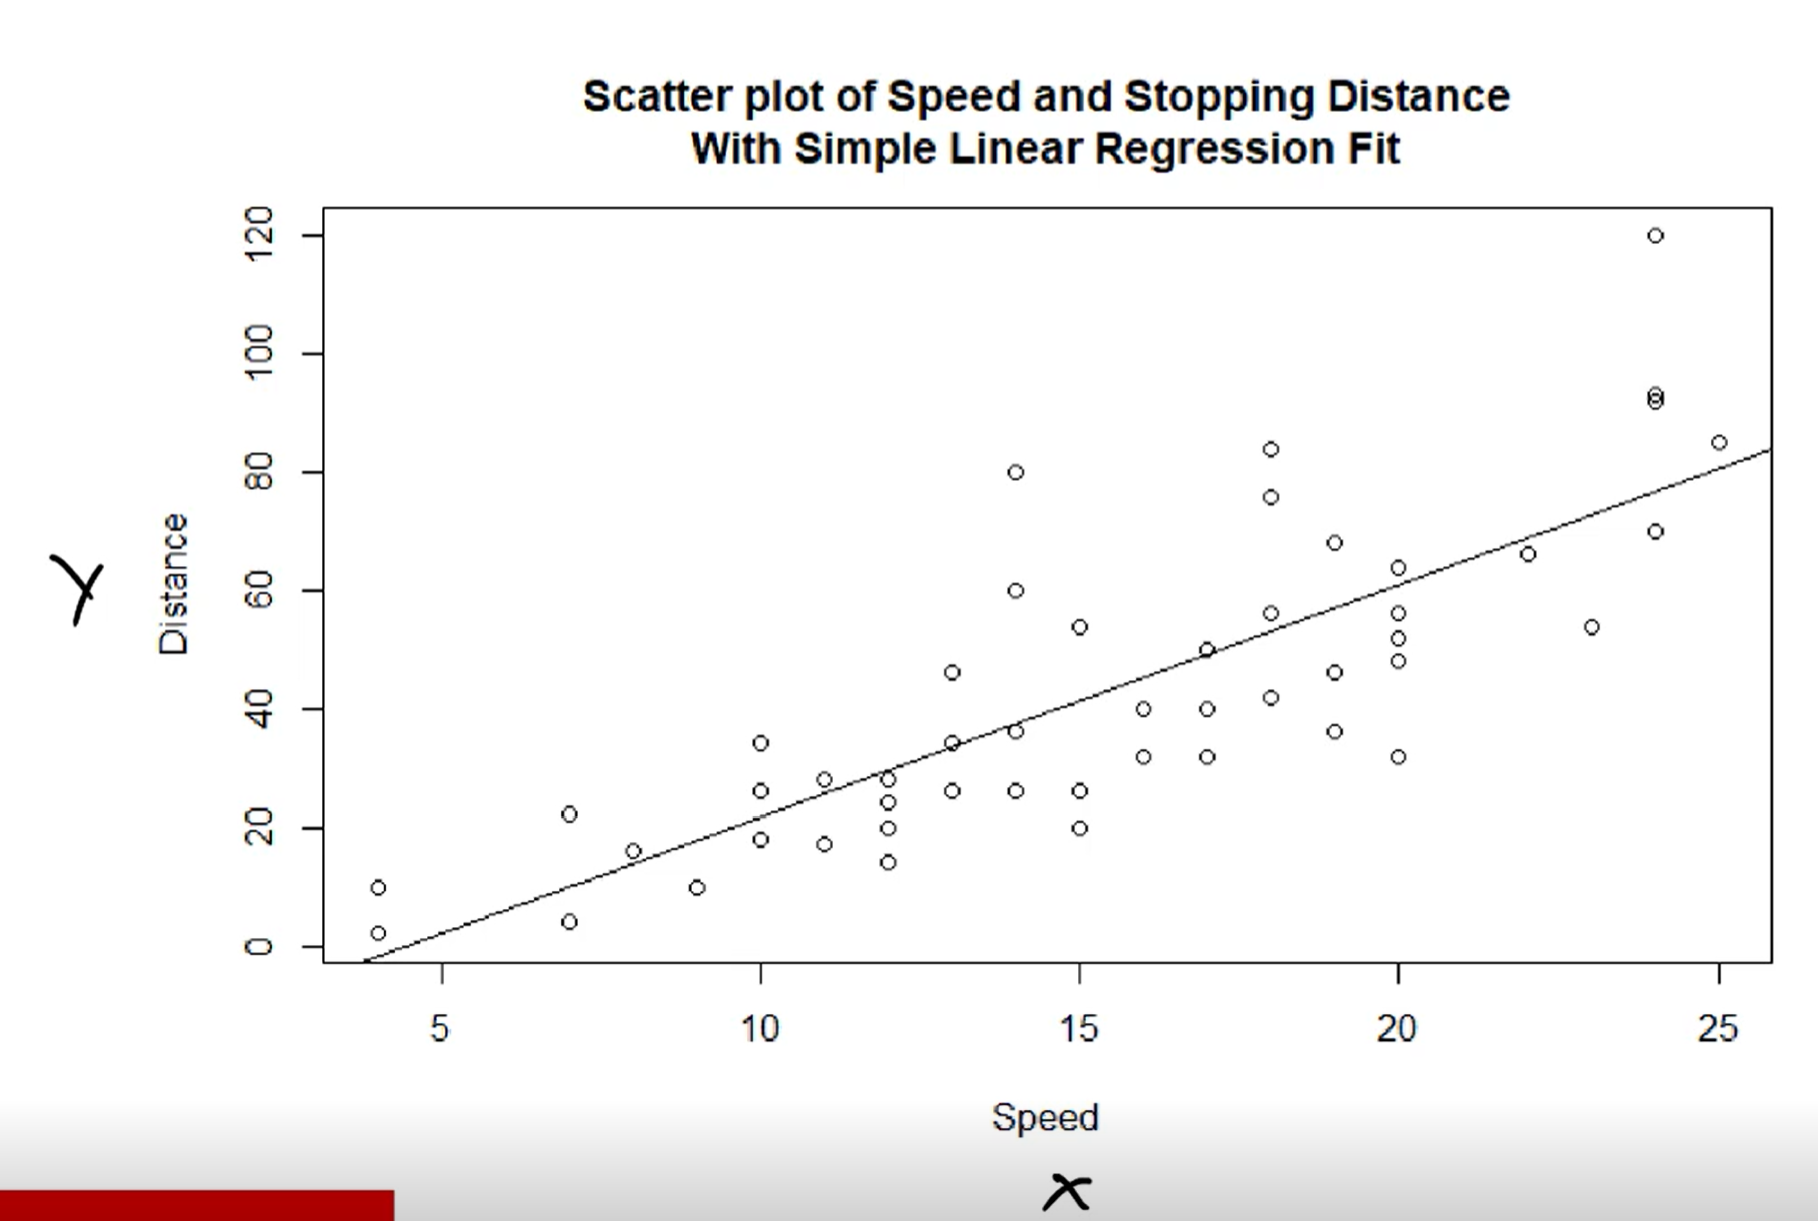

##### Regression tree

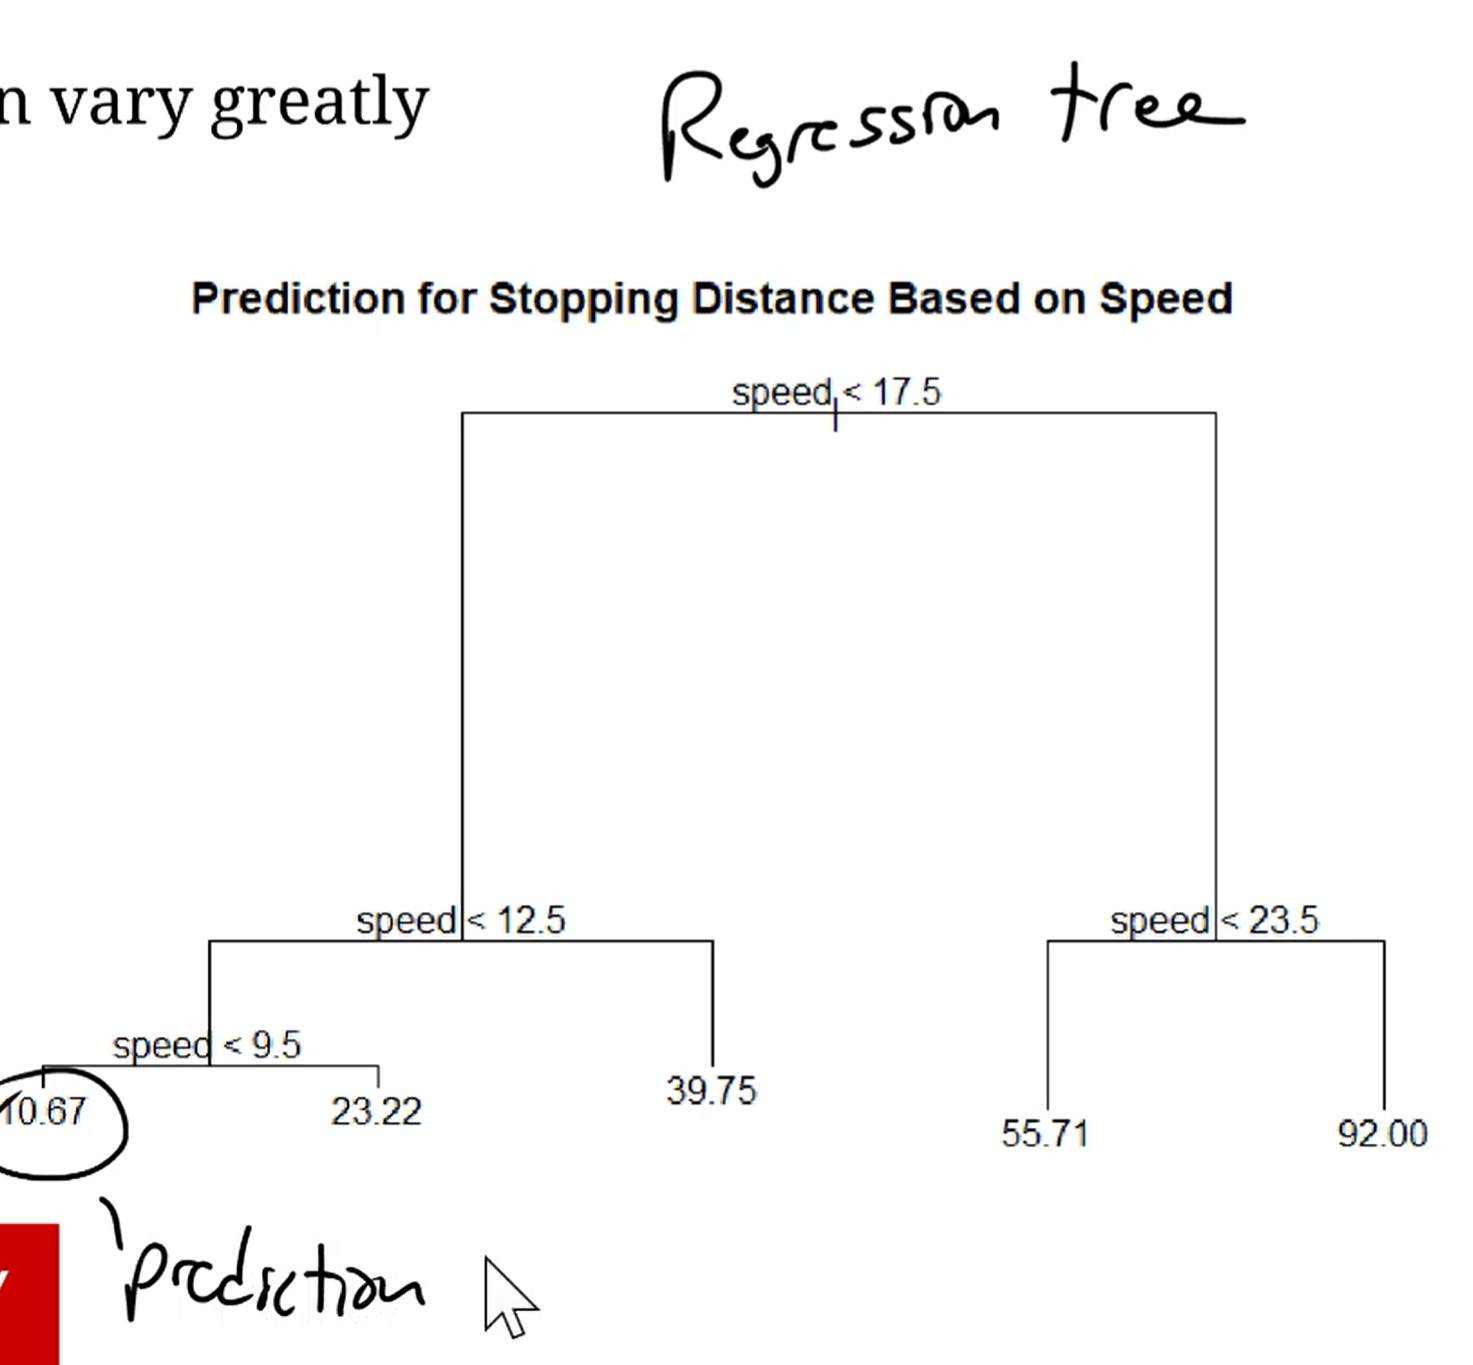

#### Types of problems

If we have a numeric response variable, we're usually solving a regression problem and trying to do a prediction. 

If our response variable is categorical, we'll be doing classification. 

#### Classification

Logistic regression, used for classification, models the probability of success given the value of a predictor.

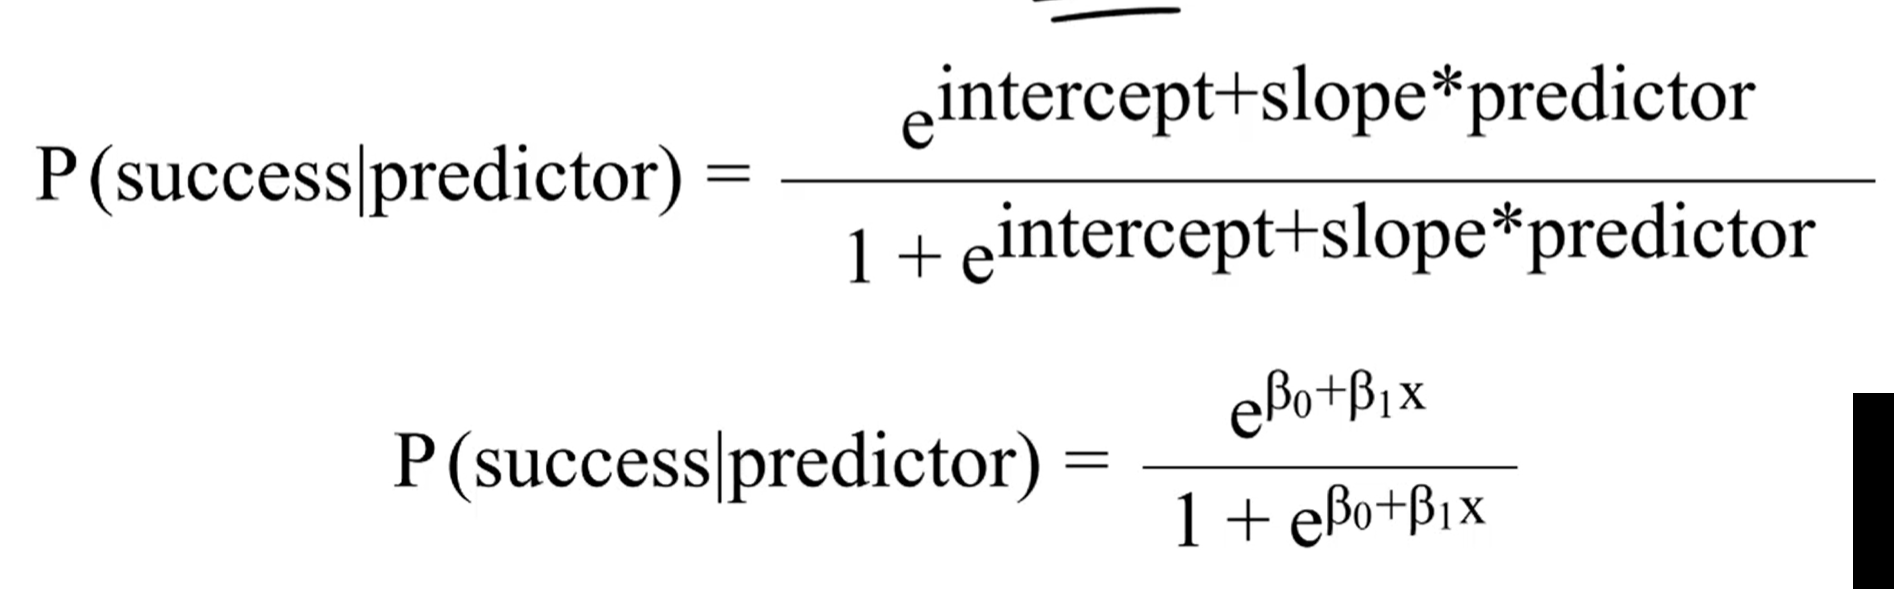

##### Models

- Regression models
    * Least squares
    * Penalized regression
    Locally weighted/splines
    * Generalized linear models (includes logistic regression)

- Tree-based methods
    * regression and classification trees
    * Random forests, boosting, bagging
    
- Naive Bayes
- k nearest neighbors

### Evaluating models

Suppose we already have a simple liner regression line. How do we determine whether the model is good?

We need a way to quantify our judgment. TO do this, we want to see how close our predictions are to the actual response. 

In [2]:
# Consider a data set on motorcycle sales prices. 
# We may consider the "selling_price" as our response variable and
# the "year", "km_driven" can be our explanatory/predictor variables
import pandas as pd
bike_data = pd.read_csv("bikeDetails.csv")
print(bike_data.columns)

Index(['name', 'selling_price', 'year', 'seller_type', 'owner', 'km_driven',
       'ex_showroom_price'],
      dtype='object')


In [3]:
bike_data.head()

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN


We can model the natural log of the selling price as our response: `log_selling_price = ln(selling_price)`. We can then consider two **simple linear regression (SLR) models**:

**Model 1** - uses "year" as a predictor
$$
\text{log_selling_price = intercept + slope*year + Error}
$$

**Model 2** - use the log of km_driven as the predictor
$$
\text{log_selling_price = intercept + slope*log_km_driven + Error}
$$

We can fit SLR models using **scikit learn**!

In [3]:
import numpy as np

# Create response and new predictor
bike_data["log_selling_price"] = np.log(bike_data["selling_price"])
bike_data["log_km_driven"] = np.log(bike_data["km_driven"])

It's OK to pass the response to sci-kit learn as a 1-D array, but not OK to pass the predictors as a 1-D array (must be 2-D). We'll need to reshape them.

print(bike_data["log_selling_price"].values) # returned as a 1-D array

In [9]:
print(bike_data["year"].values.reshape(-1, 1)) # pass each predictor as an array (must be 2-D)

[[2019]
 [2017]
 [2018]
 ...
 [2013]
 [2009]
 [2008]]


In [4]:
from sklearn import linear_model
reg1 = linear_model.LinearRegression() # create a reg object

# use .fit() to fit the SLR model. Provde x first, then y
# x must be passed as a 2-D array, y can be 1-D.
# This updates our "reg" object and now we can look at the fitted model (intercept and slope) via those attributes
reg1.fit(bike_data["year"].values.reshape(-1, 1), bike_data["log_selling_price"].values)

LinearRegression()

In [16]:
# Estimated intercept and slope from our model
print(reg1.intercept_, reg1.coef_)

-201.0631765125213 [0.10516552]


We can repeat the above for our "Model 2":

In [5]:
reg2 = linear_model.LinearRegression() # create a reg object

# use .fit() to fit the SLR model. Provde x first, then y
# x must be passed as a 2-D array, y can be 1-D.
# This updates our "reg" object and now we can look at the fitted model (intercept and slope) via those attributes
reg2.fit(bike_data["log_km_driven"].values.reshape(-1, 1), bike_data["log_selling_price"].values)

LinearRegression()

In [18]:
print(reg2.intercept_, reg2.coef_)

14.6355682846293 [-0.39108654]


We now have our 2 models, and they are both fit. Now, we want to find predictions from them using `.predict()` method!

**Model 1**
$$
\text{log_selling_price} = -201.06+0.105*year
$$

**Model 2**
$$
\text{log_selling_price} = 14.64 - 0.391*\text{log_km_driven}
$$

In [7]:
pred1 = reg1.predict(bike_data["year"].values.reshape(-1, 1))
pred2 = reg2.predict(bike_data["log_km_driven"].values.reshape(-1, 1))
pd.DataFrame(zip(pred1, pred2, bike_data["log_selling_price"]), columns = ["Model1_prediction", "Model2_prediction", "Actual"])

,Model1_prediction,Model2_prediction,Actual
0,11.266005,12.344609,12.072541
1,11.055674,11.256811,10.714418
2,11.160839,10.962225,11.918391
3,10.845343,10.707789,11.082143
4,10.424681,10.743366,9.903488
...,...,...,...
1056,10.319515,9.503589,9.740969
1057,10.529846,10.566601,9.680344
1058,10.635012,10.543589,9.615805
1059,10.214350,10.381310,9.392662


Let's quantify how well our predictions are doing. We need to import a function from `sklearn.metrics`.

In [8]:
from sklearn.metrics import mean_squared_error

# Provide true values of y and the predicted values of y to find mean_squared_error
# To get RMSE, just take square root
RMSE1 = np.sqrt(mean_squared_error(y_true = bike_data["log_selling_price"].values, y_pred = pred1))
RMSE2 = np.sqrt(mean_squared_error(y_true = bike_data["log_selling_price"].values, y_pred = pred2))

# Training RMSE values
# Smaller is better - means less loss
print(round(RMSE1, 3), round(RMSE2, 3)) # first model did a little bit better (lower value)

0.548 0.595


Since we're using trainig data, these RMSE values may not be good estimates for real-world. It's too optimistic. Let's re-do with a train-test split!

Commonly, we use an 80/20 or 70/30 split.

In [9]:
from sklearn.model_selection import train_test_split

# Function will return a list of four things:
# test/train for predictors (X)
# test/train for response(y) 
X_train, X_test, y_train, y_test = train_test_split(
    bike_data[["year", "log_km_driven"]], # feed our X variables
    bike_data["log_selling_price"],       # feed our y variable
    test_size=0.20,                       # training data makes up 80%
    random_state=42)

We then fit the model on the training set.

In [10]:
reg1 = linear_model.LinearRegression()
reg2 = linear_model.LinearRegression()

reg1.fit(X_train["year"].values.reshape(-1, 1), y_train.values)

LinearRegression()

In [11]:
reg2.fit(X_train["log_km_driven"].values.reshape(-1, 1), y_train.values)

LinearRegression()

We can look at the training RMSE if we want to:

In [12]:
# Training RMSE on the 80% of the data
train_RMSE1 = np.sqrt(mean_squared_error(y_true = y_train.values,
                                         y_pred = reg1.predict(X_train["year"].values.reshape(-1, 1))))

train_RMSE2 = np.sqrt(mean_squared_error(y_true = y_train.values,
                                         y_pred = reg2.predict(X_train["log_km_driven"].values.reshape(-1, 1))))

print(round(train_RMSE1, 3), round(train_RMSE2, 3))

0.546 0.595


Verify if RMSE still performs well on TEST data.

In [13]:
# Test RMSE on the 20% of the data
test_RMSE1 = np.sqrt(mean_squared_error(y_true = y_test.values,
                                         y_pred = reg1.predict(X_test["year"].values.reshape(-1, 1))))

test_RMSE2 = np.sqrt(mean_squared_error(y_true = y_test.values,
                                         y_pred = reg2.predict(X_test["log_km_driven"].values.reshape(-1, 1))))

print(round(test_RMSE1, 3), round(test_RMSE2, 3))

0.556 0.594


The first model wins (smaller RMSE value). Generally, when choosing a model, if the RMSE values are very close but one model is far more complicated, choose the model with better interpretability (or it runs more quickly). 

### Cross-validation

If we use only training/test sets, we may not have much data to begin with or we may get a weird split by chance. This makes the loss function evaluation a variable measurement. 

Instead, we can consider splitting the data multiple ways and averaging over the results. THis is the idea behind **cross-validation**, which is a technique that results in a less variable measurement that uses all the data when fitting. It does, however, incur a higher computational cost. 

Consider our previous two models,

**Model 1** - uses "year" as a predictor
$$
\text{log_selling_price = intercept + slope*year + Error}
$$

**Model 2** - use the log of km_driven as the predictor
$$
\text{log_selling_price = intercept + slope*log_km_driven + Error}
$$

as well as a third model,

**Model 3** - multiple linear regression (MLR) model with both variables as predictors

$$
\text{log_selling_price = intercept + slope_1*year + slope_2*log_km_driven + Error}
$$


We can assess the CV error to help us choose between these models. In sciki-learn, we have the `cross_validate()` function from the `model_selection` submodule, and it uses a `scoring` input to determine the loss function. Scoring inputs are outlined [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [20]:
# Pull in the cross_validate function
from sklearn.model_selection import cross_validate

# Create our first model
reg1 = linear_model.LinearRegression()

# Notice we do not need to fit the model first:
# cross_validate does it for us
cv1 = cross_validate(reg1,
                     bike_data["year"].values.reshape(-1, 1),  # x value followed by 
                     bike_data["log_selling_price"].values,    # y value
                     cv=5,                                     # number of folds (five-fold)
                     scoring=("r2", "neg_mean_squared_error"), # pass in loss function(s) (can do multiple at once)
                     return_train_score=True)                  # loss function across training data sets

print(sorted(cv1.keys()))

['fit_time', 'score_time', 'test_neg_mean_squared_error', 'test_r2', 'train_neg_mean_squared_error', 'train_r2']


In [21]:
# Mean squared error across the five folds (sum across all five)
# CLoser to 0 means better fit
round(sum(cv1["test_neg_mean_squared_error"]), 4)

-1.5398

We have our cross-validation for the first model. Let's repeat for the remaining ones.

In [22]:
# Create our second model
reg2 = linear_model.LinearRegression()

# All we do is change our "x" input
cv2 = cross_validate(reg2,
                     bike_data["log_km_driven"].values.reshape(-1, 1),  # x value followed by 
                     bike_data["log_selling_price"].values,             # y value
                     cv=5,                                     
                     scoring=("r2", "neg_mean_squared_error"), )
                     return_train_score=True)                  

# Create our third model
reg3 = linear_model.LinearRegression()

# Notice we do not need to fit the model first:
# cross_validate does it for us
cv3 = cross_validate(reg3,
                     bike_data[["year", "log_km_driven"]].values,  # two x variables 
                     bike_data["log_selling_price"].values,        
                     cv=5,                                         
                     scoring=("r2", "neg_mean_squared_error"),     
                     return_train_score=True)                      

print(round(sum(cv1["test_neg_mean_squared_error"]), 4),
      round(sum(cv2["test_neg_mean_squared_error"]), 4),
            round(sum(cv3["test_neg_mean_squared_error"]), 4))

-1.5398 -1.8127 -1.3416


It looks like our multiple linear regression (MLR) model is best. Now we would refit the best model on the full data set!

#### Using CV with more complicated models

##### LASSO model

Very similar to a regression model, but it adds a penalty term to the algorithm used to fit the model. A tuning parameter, $\alpha$, can be adjusted (when $\alpha$ is 0, we have MLR). As $\alpha$ gets bigger, the size of our $\beta$s is penalized (i.e. they shrink, getting closer and closer to 0). 

Cross-validation can help us select the right $\alpha$!

If there's a specific $\alpha$ that we want to inspect, we can do the following:

In [25]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(bike_data[["year", "log_km_driven"]].values, bike_data["log_selling_price"].values) # x followed by y

Lasso(alpha=0.1)

In [26]:
print(lasso.intercept_, lasso.coef_) # intercept and slope

-164.6120947286609 [ 0.08761607 -0.11092474]


In [27]:
# Try another alpha value
lasso = linear_model.Lasso(alpha=1.05)
lasso.fit(bike_data[["year", "log_km_driven"]].values, bike_data["log_selling_price"].values)

Lasso(alpha=1.05)

In [28]:
print(lasso.intercept_, lasso.coef_)

-86.65630892150766 [ 0.04835598 -0.        ]


For every $\alpha$, there is a different model. How do we find the best value? We have the `LassoCV` function!

In [29]:
from sklearn.linear_model import LassoCV
lasso_mod = LassoCV(cv=5, random_state=0) \ # random_state sets a seed
    .fit(bike_data[["year", "log_km_driven"]].values, # x
         bike_data["log_selling_price"].values)       # y
lasso_mod.alpha_    # optimal alpha

0.0019437543528236258

Now that we have an optimal $\alpha$, we can fit our model. 

In [30]:
lasso_best = linear_model.Lasso(lasso_mod.alpha_)
lasso_best.fit(bike_data[["year", "log_km_driven"]].values, bike_data["log_selling_price"].values)

Lasso(alpha=0.0019437543528236258)

In [31]:
print(lasso_best.intercept_, lasso_best.coef_)

-149.10698119300122 [ 0.08048115 -0.22460153]


#### When to use CV

If we just have one family of models (e.g. Lasso, simple linear regression, etc.), we can use a training/set set or k-fold CV.

When we have multiple families of models, we should really use both. 

## Module 13 - Common Supervised Learning Models

### Linear Regression

We typically use `x` to denote predictors and `y` to denote responses. If we have `n` responses, $y_1, y_2,...,y_n$, and we wish to predict some future value, it's very common to use the sample mean, $\bar{y}$. 

With multiple liner regression (MLR) models, the idea is to find the line, plane, saddle, etc. **of best fit** through our data points. If we have our theoretical $\beta_1$, $\beta_2$, etc,. how do we find the best fit - that is, how do we select our $\hat{\beta}$s (beta hats)?

Usually, we minimize the sum of squared **residuals** (errors), where

$$
\text{residuals = observed - predicted or } y_i-\hat{y}_i
$$

and $\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1x_{1i} + \ldots + \hat{\beta}_px_{pi}$. Thus, minimizing the squared residuals is just

$$
min_{\hat{\beta}s} = \sum_{i=1}^n(y_i - (\hat{\beta}_0 + \hat{\beta}_1x_{1i} + \ldots + \hat{\beta}_px_{pi}))^2
$$

#### Fitting a linear regression model in Python

In [1]:
import pandas as pd
import numpy as np
bike_data = pd.read_csv("bikeDetails.csv")

# Create response and new predictor
bike_data['log_selling_price'] = np.log(bike_data['selling_price'])
bike_data['log_km_driven'] = np.log(bike_data['km_driven'])

In [2]:
# Simple linear regression
from sklearn import linear_model
slr_fit = linear_model.LinearRegression()
slr_fit.fit(bike_data['log_km_driven'].values.reshape(-1,1), bike_data['log_selling_price'].values) # x followed by y

LinearRegression()

In [3]:
print(slr_fit.intercept_, slr_fit.coef_)

14.6355682846293 [-0.39108654]


Text(0, 0.5, 'log_selling_price')

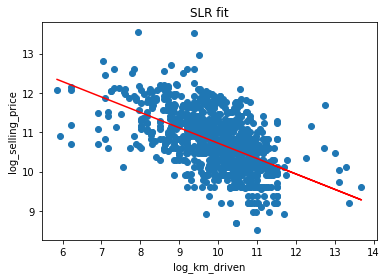

In [9]:
import matplotlib.pyplot as plt
preds = slr_fit.predict(bike_data['log_km_driven'].values.reshape(-1,1)) # "preds" are the y-hats - predictions for every row of x
plt.scatter(bike_data['log_km_driven'].values.reshape(-1,1), bike_data['log_selling_price'].values)
plt.plot(bike_data['log_km_driven'].values.reshape(-1,1), preds, 'red')
plt.title("SLR fit")
plt.xlabel("log_km_driven")
plt.ylabel("log_selling_price")

How do we include a categorical variable? We can use the `get_dummies()` function from `pandas` to create dummy/indicator variables.

In [10]:
# Gemerate an array of indicator variables for a particular categorical variable
pd.get_dummies(data = bike_data["owner"])

,1st owner,2nd owner,3rd owner,4th owner
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0
...,...,...,...,...
1056,1,0,0,0
1057,1,0,0,0
1058,0,1,0,0
1059,1,0,0,0


We can add this new binary variable to our data set.

In [11]:
bike_data["one_owner"] = pd.get_dummies(data = bike_data["owner"])['1st owner'] # get just "1st owner" column
mlr_fit = linear_model.LinearRegression()
# Pass 2 "x" columns, fit SLR model with different intercepts
mlr_fit.fit(bike_data[['log_km_driven', 'one_owner']], bike_data['log_selling_price'].values) 

LinearRegression()

In [12]:
# Beta_0 hat, beta_1 hat, beta_2 hat
print(mlr_fit.intercept_, mlr_fit.coef_)

14.570541645783868 [-0.38893985  0.05002779]


InvalidIndexError: (slice(None, None, None), None)

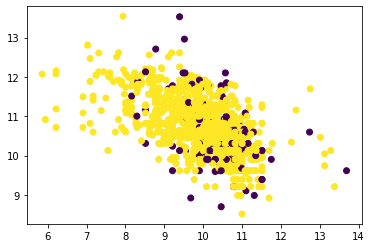

In [15]:
# Create 2 sets of y-hats - one for the one_owner == 0 column and
# one_owner == 1 column
preds1 = mlr_fit.predict(bike_data.loc[bike_data['one_owner'] == 0, ['log_km_driven', 'one_owner']])
preds2 = mlr_fit.predict(bike_data.loc[bike_data['one_owner'] == 1, ['log_km_driven', 'one_owner']])

plt.scatter(bike_data['log_km_driven'].values.reshape(-1,1), bike_data['log_selling_price'].values,
            c = bike_data['one_owner'].values)
plt.plot(bike_data.loc[bike_data['one_owner'] == 0, ['log_km_driven']], preds1,
         c = 'orange', label = "One owner")
plt.plot(bike_data.loc[bike_data['one_owner'] == 1, ['log_km_driven']], preds2,
         c = 'purple', label = "Multiple owner")

plt.title("Different Intercept SLR Fit")
plt.xlabel('log_km_driven')
plt.ylabel('log_selling_price')
plt.legend()

We can split our data into train and test sets.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    bike_data[["year", "log_km_driven", "one_owner"]],
    bike_data["log_selling_price"],
    test_size=0.20,
    random_state=42)

We can then find the cross-validation error.

In [23]:
from sklearn.model_selection import cross_validate
cv = cross_validate(linear_model.LinearRegression(), X_train, y_train, cv = 5, scoring = "neg_root_mean_squared_error")

In [22]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

### Logistic Regression

Logistic regression models a binary response (0=failure or 1=success), rather than a numeric response. The average of a binary response represents the probability of success, $P(Y = 1)$.

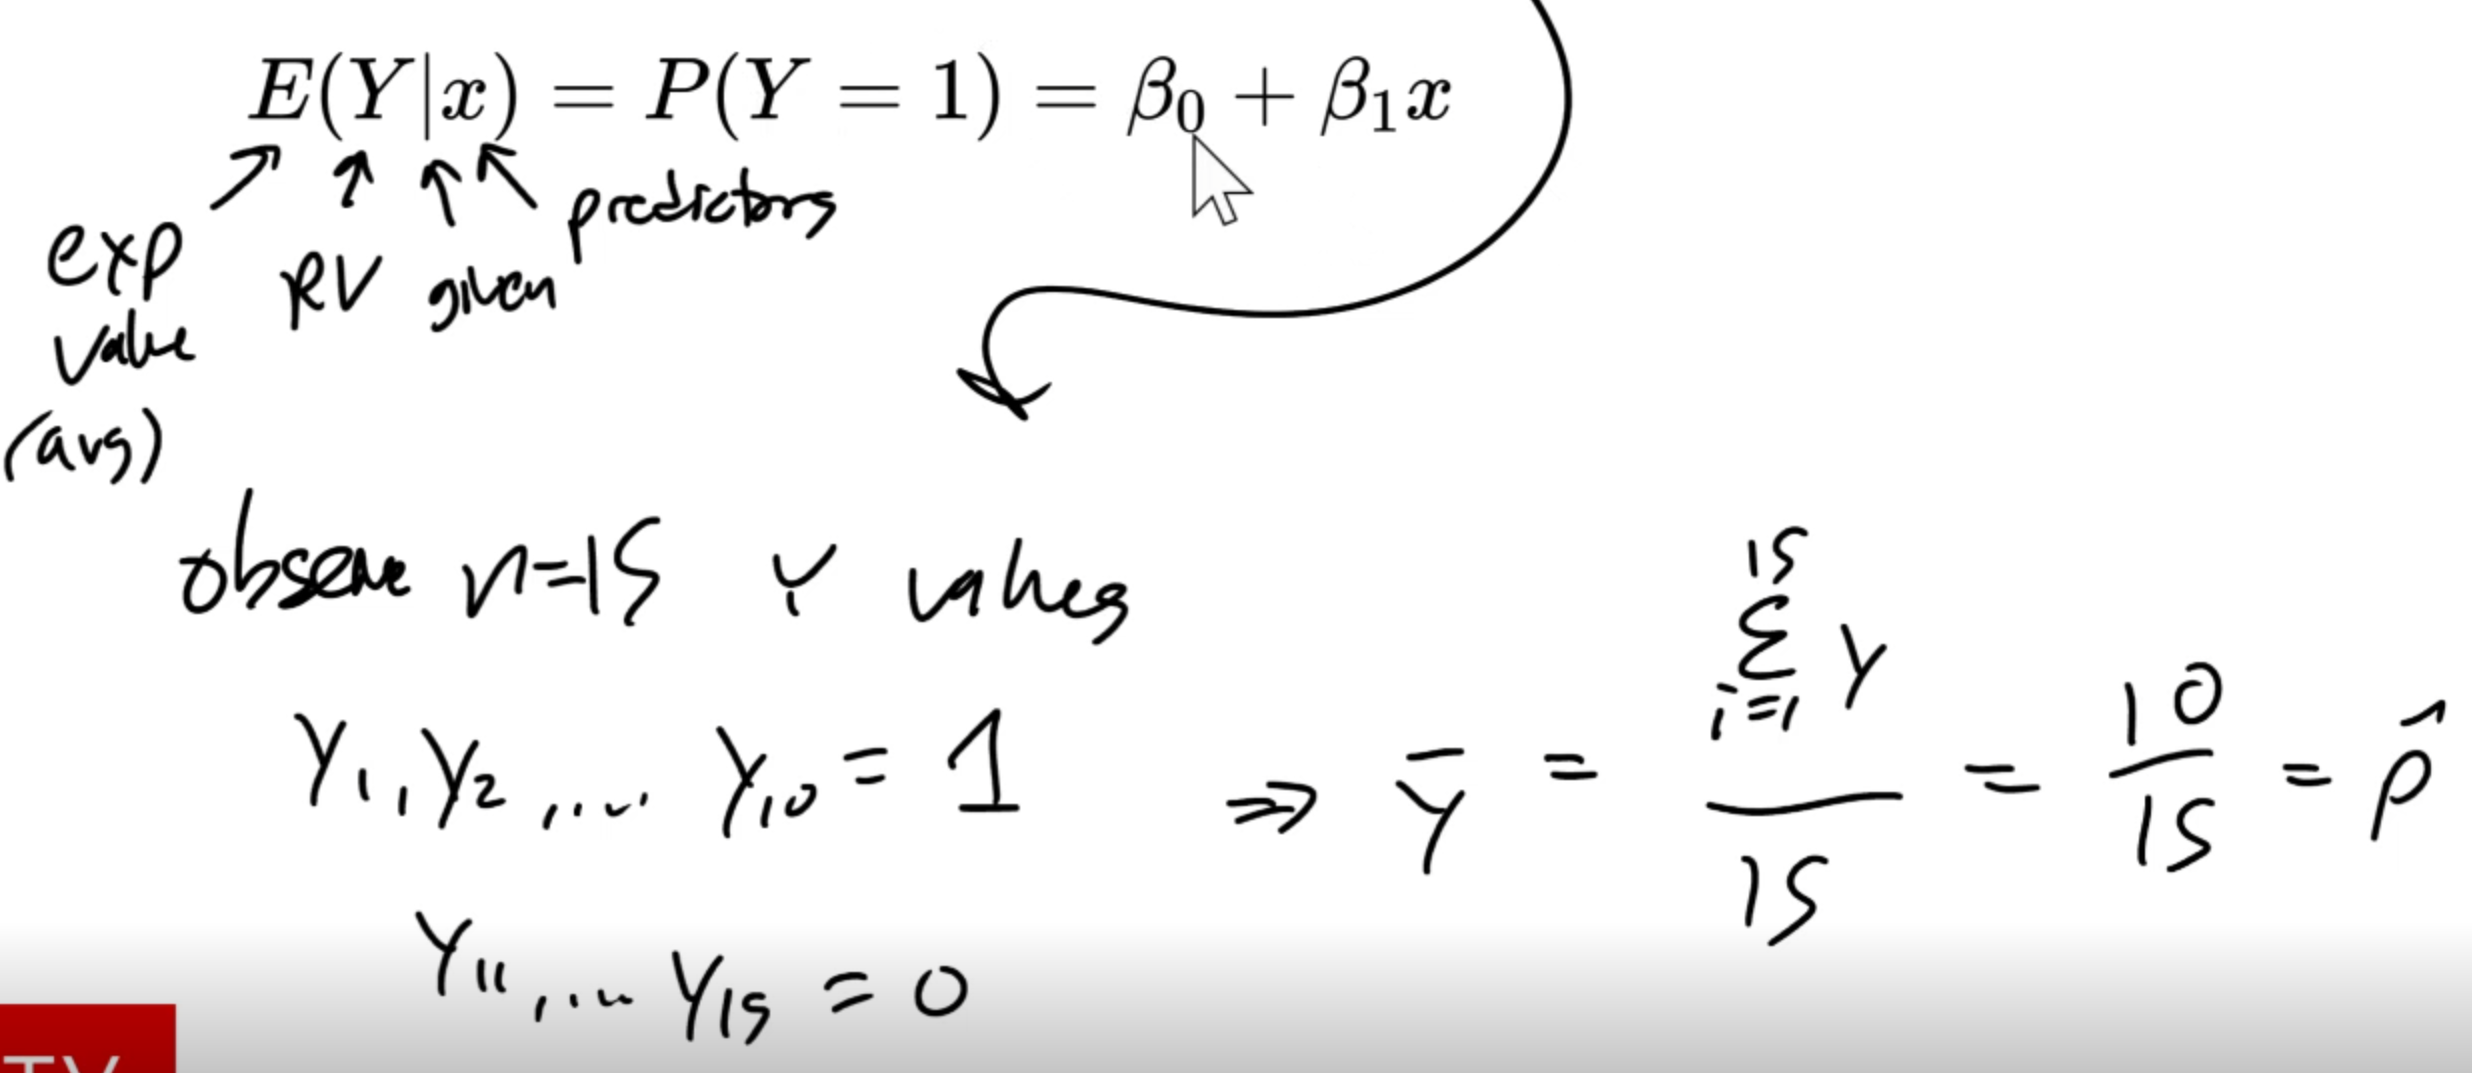

Logistic regression falls into a family of generalized linear models (GLMs). This allows for responses from non-normal distributions.

Let's look at an example data set to see why SLR is not appropriate when we have a binary response.

In [2]:
# Example data set of drinkable water
# Potability is our binary response
import pandas as pd
water = pd.read_csv("water_potability.csv")
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
water.Potability.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

In [7]:
# Consider different grouping of potability
water.groupby("Potability")[["Hardness", "Chloramines"]].describe()

Hardness                                                            \
              count        mean        std        min         25%         50%   
Potability                                                                      
0            1998.0  196.733292  31.057540  98.452931  177.823265  197.123423   
1            1278.0  195.800744  35.547041  47.432000  174.330531  196.632907   

                                   Chloramines                                \
                   75%         max       count      mean       std       min   
Potability                                                                     
0           216.120687  304.235912      1998.0  7.092175  1.501045  1.683993   
1           218.003420  323.124000      1278.0  7.169338  1.702988  0.352000   

                                                     
                 25%       50%       75%        max  
Potability                                           
0           6.155640  7.090334  8.066462  12.653362  
1           6.094134  7.215163  8.199261  13.127000

Text(0, 0.5, 'Potability')

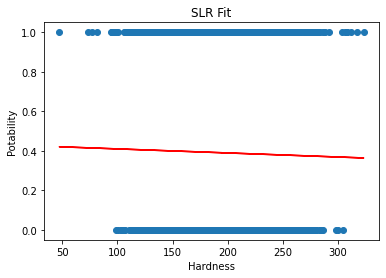

In [8]:
# Check out what SLR looks like here (recall that SLR is not appropriate)
import matplotlib.pyplot as plt
from sklearn import linear_model

slr_fit = linear_model.LinearRegression() #Create a reg object
slr_fit.fit(water['Hardness'].values.reshape(-1,1), water['Potability'].values)

preds = slr_fit.predict(water['Hardness'].values.reshape(-1,1))

plt.scatter(water['Hardness'].values.reshape(-1,1),water['Potability'].values.reshape(-1,1))
plt.plot(water['Hardness'].values.reshape(-1,1), preds, 'red')
plt.title("SLR Fit")
plt.xlabel('Hardness')
plt.ylabel('Potability')

Since "Potability" takes on only 2 values, we see that the SLR model is trying to model the average of the two and is not appropriate.

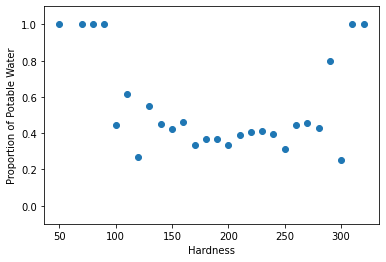

In [9]:
# A better view of the data

# Split up water hardness into groups starting at 45, going by 10s, up to 335
water["Hardnessgroups"] = pd.cut(water['Hardness'], range(45, 335, 10))
# Find the Potability means
props = water.groupby("Hardnessgroups").Potability.mean()

# Note that the line in the plot above was trying to model the middle points
plt.scatter(pd.Series(range(50,330,10)), props.values)
plt.xlabel("Hardness"); plt.ylabel("Proportion of Potable Water"); plt.ylim([-0.1, 1.1]); plt.show()

What do we need to change to deal with this binary response? Our predictions should never go below 0 or above 1. Therefore, we can fit a logistic regression model where the function betas are exponentials ($e$) and thus, no longer linear.

$$
P(success|x) = \frac{e^{\beta_0 + \beta_1x}}{1+e^{\beta_0 + \beta_1x}}
$$

A plot of this function will look like a sigmoid. 

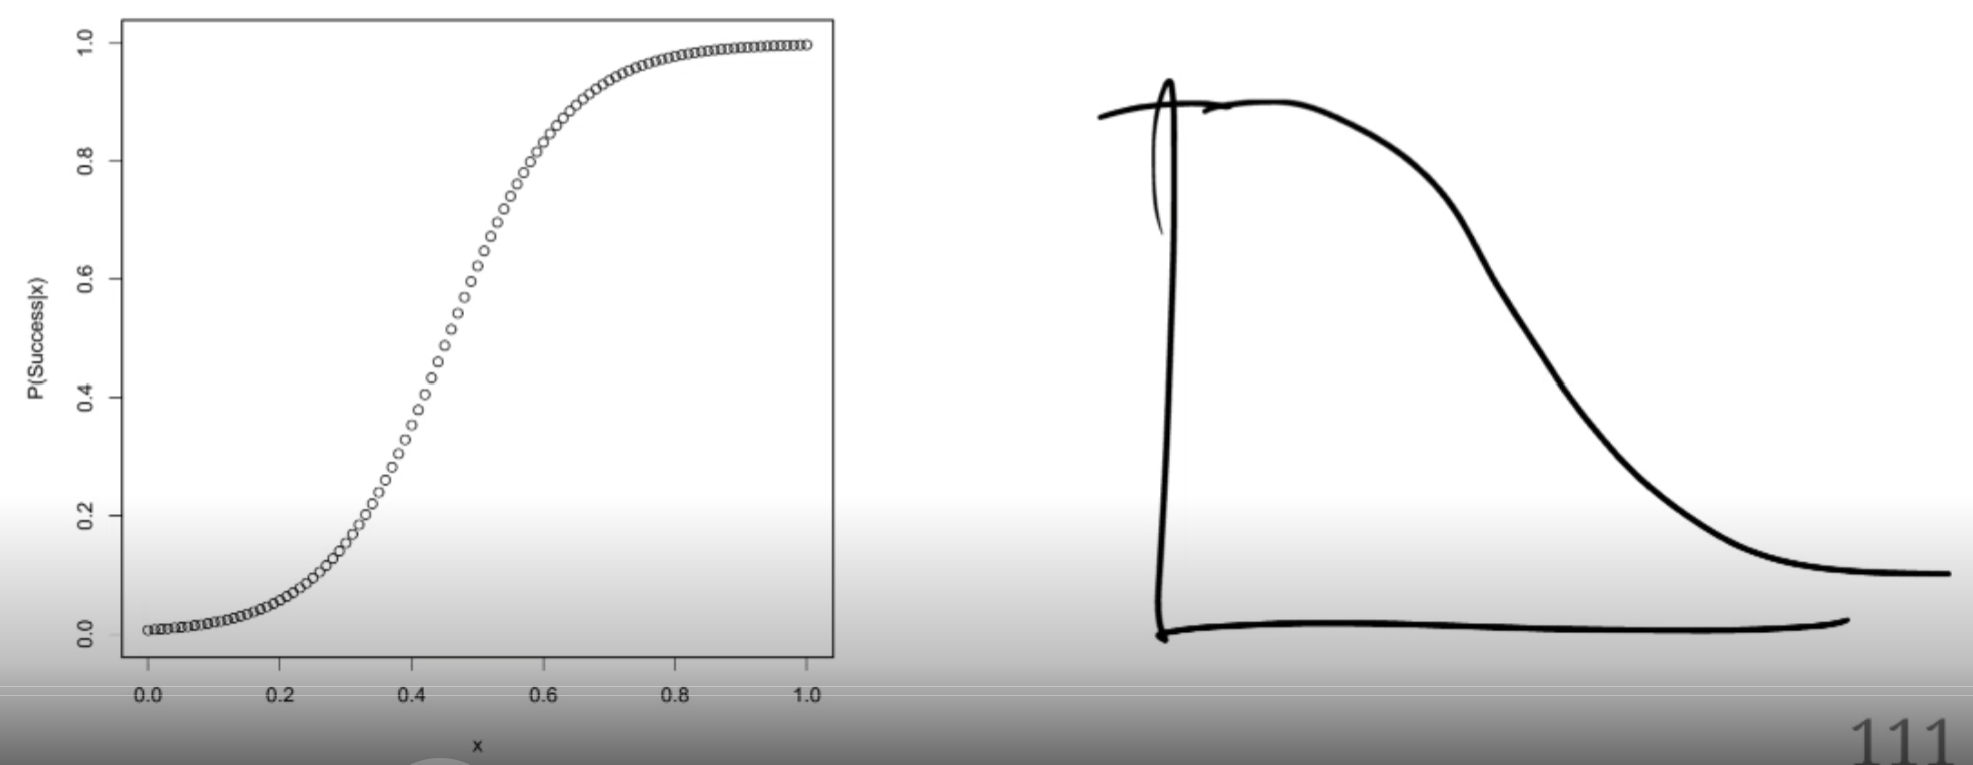

Back-solving the equation above gives us the _logit_, or the _log-odds_ of success that is linear in the parameters.

$$
log(\frac{P(success|x)}{1-P(sucess|x)}) = \beta_0 + \beta_1x
$$

In [12]:
from sklearn.linear_model import LogisticRegression

# By default, there is a shrinkage penalty, similar to LASSO,
# so this is (by default) a smooth logistic regresion. 
# By adding "penalty=none", we get just the basic logistic regression model
log_reg = LogisticRegression(penalty = "none")
log_reg.fit(X = water["Hardness"].values.reshape(-1,1), y=water["Potability"].values) # x followed by y

LogisticRegression(penalty='none')

In [13]:
# Intercept (beta_0 hat) and slope (beta_1 hat)
print(log_reg.intercept_, log_reg.coef_)

[-0.27748213] [[-0.00086296]]


In [17]:
import numpy as np

# The "x"s that we want to predict for
log_reg.predict(np.array([[50], [150], [200], [250], [300]])) # np.array creates a column vector

# [50 ]
# |150|
# |200|
# |250|
# [300]

# Predicted class for all of these is 0 (not potable) for all of these observations

array([0, 0, 0, 0, 0], dtype=int64)

We can also think about a few other predictions - the log of the probabilities (`.predict_log_proba()`) or the probability of being a 1 or a 0 (`.predict_proba()`).

In [18]:
log_reg.predict_proba(np.array([[50], [150], [200], [250], [300]]))

# Result is probability that y=0 and prob of y=1
# P(Y=0), P(Y=1)
# As we go down, probability of being potable decreases;
# that is, the more hardness in the water, the lss potable it is

array([[0.57947776, 0.42052224],
       [0.60035045, 0.39964955],
       [0.61065667, 0.38934333],
       [0.62086496, 0.37913504],
       [0.63096734, 0.36903266]])

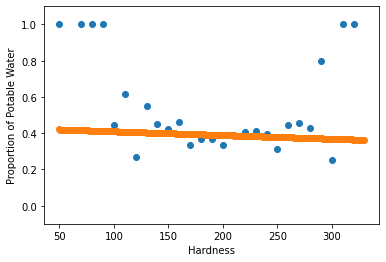

In [19]:
# Plot the means of the hardness
plt.scatter(pd.Series(range(50,330,10)), props.values)

preds = log_reg.predict_proba(np.array(range(50,330)).reshape(-1,1))

plt.scatter(x = np.array(range(50,330)), y = preds[:,1])
plt.ylim([-0.1,1.1]); plt.xlabel("Hardness"); plt.ylabel("Proportion of Potable Water"); plt.show()

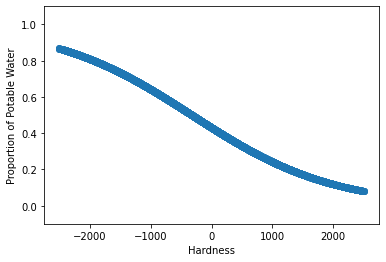

In [21]:
# Zoom waaay out with a range from -2500 to 2500
# to see the sigmoid function
preds = log_reg.predict_proba(np.array(range(-2500,2500)).reshape(-1,1))
plt.scatter(x = np.array(range(-2500,2500)), y = preds[:,1])
plt.ylim([-0.1,1.1]); plt.xlabel("Hardness"); plt.ylabel("Proportion of Potable Water"); plt.show()

We can make our model much more complicated by fitting interaction effects, polynomial terms, and categorical variables via dummy variables.

Let's look at a model with 3 "x"s in it:

In [22]:
log_reg = LogisticRegression(penalty = "none")
log_reg.fit(X = water[["Hardness", "Solids", "Chloramines"]].values, y = water["Potability"].values)

LogisticRegression(penalty='none')

The above corresponds to a model of 

$$
log(odds) = \beta_0 + \beta_1Hardness + \beta_2Solids + \beta_3Chlorines
$$

Next, we can find estimated probabilities for a model by providing an array in which each row is hardness, solids, and chlorines.

In [23]:
log_reg.predict_proba(np.array([[175, 15666, 6.12],
                               [175, 15666, 8.11],
                               [217, 15666, 6.12],
                               [217, 15666, 8.11],
                               [196, 22014, 7.12],
                               [217, 22014, 8.11]]))

# P(Y=0), P(Y=1)

array([[0.60039733, 0.39960267],
       [0.60043692, 0.39956308],
       [0.62742922, 0.37257078],
       [0.62746779, 0.37253221],
       [0.60739832, 0.39260168],
       [0.62093361, 0.37906639]])

We've fit our models - how do we actually select one? We may have many.

Recall that we can use k-fold cross-validation or actual test error itself. We need a loss function to determine how well we're doing. We can look at accuracy,

$$
\text{Accuracy = } \frac{\text{# of correct classifications}}{\text{Total # of classifications}}
$$

or misclassification rate,

$$
\text{Misclassification rate = } \frac{\text{# of incorrect classifications}}{\text{Total # of classifications}}
$$

In [25]:
# Use k-fold cross-validation to judge our model
# Accuracy is used by default when we use logistic regression
from sklearn.model_selection import cross_validate

# penalty = "none" means we're doing regular logistic regression
log_reg1 = LogisticRegression(penalty = "none")

#
cv1 = cross_validate(log_reg1,
      X = water[["Hardness", "Solids", "Chloramines"]].values,
      y = water["Potability"].values,
      cv = 5)

# Provides accuracy - number of correct/number of total classifications for fold 0, 1, 2, 3, and 4 (5 total)
cv1['test_score']

array([0.6097561 , 0.61068702, 0.61068702, 0.60916031, 0.61221374])

We can fit a second model by including a few extra "x"s:

In [26]:
cv2 = cross_validate(log_reg1,
      water[["Hardness", "Solids", "Chloramines", "Conductivity", "Organic_carbon"]].values,
      y = water["Potability"].values,
      cv = 5)

Here's a polynomial:

In [29]:
from sklearn.preprocessing import PolynomialFeatures

# interaction_only=True means don't worry about polynomials, just give me the
# interactions between the x's
# include_bias = False means don't standardize the predictors. Often we want to, though. 
poly = PolynomialFeatures(interaction_only=True, include_bias = False)

# Given the x's that we pass, create interactions
poly.fit_transform(water[["Hardness", "Solids", "Chloramines"]])

array([[2.04890455e+02, 2.07913190e+04, 7.30021187e+00, 4.25994282e+06,
        1.49574374e+03, 1.51781034e+05],
       [1.29422921e+02, 1.86300579e+04, 6.63524588e+00, 2.41115650e+06,
        8.58752901e+02, 1.23615015e+05],
       [2.24236259e+02, 1.99095417e+04, 9.27588360e+00, 4.46444116e+06,
        2.07998944e+03, 1.84678592e+05],
       ...,
       [1.75762646e+02, 3.31555782e+04, 7.35023323e+00, 5.82751217e+06,
        1.29189644e+03, 2.43701233e+05],
       [2.30603758e+02, 1.19838694e+04, 6.30335653e+00, 2.76352531e+06,
        1.45357770e+03, 7.55386013e+04],
       [1.95102299e+02, 1.74041771e+04, 7.50930586e+00, 3.39559495e+06,
        1.46508283e+03, 1.30693289e+05]])

In [28]:
# Includes the original variables AND the interactions
cv3 = cross_validate(log_reg1,
      poly.fit_transform(water[["Hardness", "Solids", "Chloramines"]]),
      y = water["Potability"].values,
      cv = 5)

The model above includes all main effects and interaction words and looks like 

$$
\beta_0 + \beta_1H + \beta_2S + \beta_3C + \beta_4H*S + \beta_5H*C + \beta_0S*C
$$

`cv1`, `cv2`, and `cv3` all have the output of the `cross_validate` function for test scores. They were accuracy measures for each fold, and we want to combine them. We can do this by just finding the average.

In [30]:
[round(cv1['test_score'].mean(),4), round(cv2['test_score'].mean(),4), round(cv3['test_score'].mean(),4)]

[0.6105, 0.6099, 0.6084]

The simplest model appears to have been the best.

### Tree Models

#### Regression trees - used for continuous type response

Very different from MLR. They are still used when we have a numeric response, but we split up our predictor space into different regions. Then, we'll use different predictions for each region.

Our prediction is usually the _mean_ of the responses. This is the optimal prediction for squared error loss. 

![](2022-04-16-15-38-22.png)

###### How do we fit a regression tree?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bike_data = pd.read_csv('bikeDetails.csv')

# Create response and new predictor
bike_data['log_selling_price'] = np.log(bike_data['selling_price'])
bike_data['log_km_driven'] = np.log(bike_data['km_driven'])

Next, we need to import the `DecisionTreeRegressor` function from `sklearn`.

In [7]:
from sklearn.tree import DecisionTreeRegressor

# Depth represents how many splits we're doing
regr1 = DecisionTreeRegressor(max_depth=2) # max of 2 splits
regr2 = DecisionTreeRegressor(max_depth=5) 
regr1.fit(X = bike_data['log_km_driven'].values.reshape(-1,1), y = bike_data['log_selling_price'].values)

DecisionTreeRegressor(max_depth=2)

We can use cross-validation to determine the `max_depth'.

In [8]:
regr2.fit(X = bike_data['log_km_driven'].values.reshape(-1,1), y = bike_data['log_selling_price'].values)

DecisionTreeRegressor(max_depth=5)

We can use the `predict` method to get our predictions.

In [14]:
X_test = np.arange(5.8, 13.8, 0.1)[:, np.newaxis] # create a grid of "x" values to test for, from 5.8 to 13.8 by 0.1
pred1 = regr1.predict(X_test)
pred2 = regr2.predict(X_test)

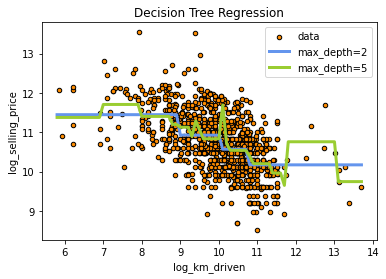

In [15]:
plt.scatter(bike_data['log_km_driven'], bike_data['log_selling_price'],
            s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, pred1, color="cornflowerblue", label="max_depth=2", linewidth=3)
plt.plot(X_test, pred2, color="yellowgreen", label="max_depth=5", linewidth=3)
plt.xlabel("log_km_driven")
plt.ylabel("log_selling_price")
plt.title("Decision Tree Regression")
plt.legend()

The blue line had only a depth of 2 (fewer split points) and the plot shows it to be much less variable. A max. depth of 5 is more fine-tuned, but we may be overfitting to our data. This is why we use cross-validation or a test set - to ensure we do not overfit!

We can extend regression trees to more than one predictor. Even better, we do not have to manually specify interaction or polynomial terms - regression trees automatically take those into account. 

To accomodate more than one predictor, we simply specify more "x" variables.

In [16]:
from sklearn.tree import DecisionTreeRegressor

regr3 = DecisionTreeRegressor(max_depth=2)
regr3.fit(bike_data[['log_km_driven', 'year']].values, bike_data['log_selling_price']) # more than 1 predictor

DecisionTreeRegressor(max_depth=2)

[Text(0.5, 0.8333333333333334, 'X[1] <= 2014.5\nsquared_error = 0.505\nsamples = 1061\nvalue = 10.726'),
 Text(0.25, 0.5, 'X[1] <= 2009.5\nsquared_error = 0.359\nsamples = 501\nvalue = 10.299'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.404\nsamples = 146\nvalue = 9.92'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.257\nsamples = 355\nvalue = 10.455'),
 Text(0.75, 0.5, 'X[0] <= 9.2\nsquared_error = 0.326\nsamples = 560\nvalue = 11.109'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.334\nsamples = 162\nvalue = 11.478'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.245\nsamples = 398\nvalue = 10.958')]

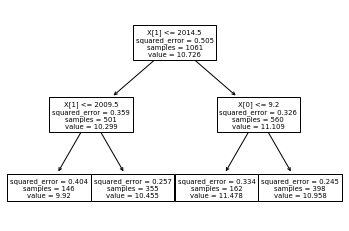

In [17]:
# Visualzie the tree that we fit
from sklearn.tree import plot_tree
plot_tree(regr3)

# log_km_driven is x[0]
# year is x[1]

It's also easy to include categorical variables. Just like before, we simply create dummy variables.

In [18]:
regr4 = DecisionTreeRegressor(max_depth=3)
pd.get_dummies(bike_data.owner).head()

,1st owner,2nd owner,3rd owner,4th owner
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0


In [19]:
bike_data["owners"] = pd.get_dummies(bike_data.owner)['1st owner'] # create a binary variable
regr4.fit(bike_data[['log_km_driven', 'owners']].values, bike_data['log_selling_price'].values) # include the binary variable as an owner

DecisionTreeRegressor(max_depth=3)

[Text(0.5, 0.875, 'X[0] <= 10.075\nsquared_error = 0.505\nsamples = 1061\nvalue = 10.726'),
 Text(0.25, 0.625, 'X[0] <= 8.941\nsquared_error = 0.449\nsamples = 497\nvalue = 11.084'),
 Text(0.125, 0.375, 'X[0] <= 7.963\nsquared_error = 0.389\nsamples = 149\nvalue = 11.448'),
 Text(0.0625, 0.125, 'squared_error = 0.535\nsamples = 38\nvalue = 11.691'),
 Text(0.1875, 0.125, 'squared_error = 0.312\nsamples = 111\nvalue = 11.366'),
 Text(0.375, 0.375, 'X[0] <= 9.55\nsquared_error = 0.393\nsamples = 348\nvalue = 10.928'),
 Text(0.3125, 0.125, 'squared_error = 0.416\nsamples = 136\nvalue = 11.075'),
 Text(0.4375, 0.125, 'squared_error = 0.356\nsamples = 212\nvalue = 10.834'),
 Text(0.75, 0.625, 'X[0] <= 10.749\nsquared_error = 0.342\nsamples = 564\nvalue = 10.411'),
 Text(0.625, 0.375, 'X[1] <= 0.5\nsquared_error = 0.296\nsamples = 337\nvalue = 10.571'),
 Text(0.5625, 0.125, 'squared_error = 0.421\nsamples = 49\nvalue = 10.424'),
 Text(0.6875, 0.125, 'squared_error = 0.27\nsamples = 288\nvalue

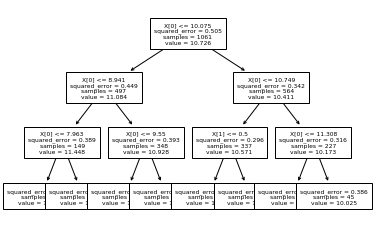

In [20]:
plot_tree(regr4, fontsize=6)

### Classification tree

We still split up our predictions into classification spaces, but we _classify_ based on those regions. The most prevalent class wins (majority rule). 

In [21]:
water = pd.read_csv('water_potability.csv')
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In our `water_potability.csv` data set, we're looking at the "Potability" variable, where Potability=0 means the water is not drinkable and Potability=1 means the water is drinkable.

We can sue a `DecisionTreeClassifier` to fit classification trees.

In [23]:
from sklearn.tree import DecisionTreeClassifier

cltree1 = DecisionTreeClassifier(max_depth=3) # number of splits
cltree1.fit(X = water[['Hardness', 'Solids']].values, y = water['Potability'].values) 

DecisionTreeClassifier(max_depth=3)

[Text(0.4230769230769231, 0.875, 'X[0] <= 164.264\ngini = 0.476\nsamples = 3276\nvalue = [1998, 1278]'),
 Text(0.15384615384615385, 0.625, 'X[0] <= 98.41\ngini = 0.498\nsamples = 513\nvalue = [274, 239]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(0.23076923076923078, 0.375, 'X[1] <= 26493.556\ngini = 0.496\nsamples = 504\nvalue = [274, 230]'),
 Text(0.15384615384615385, 0.125, 'gini = 0.489\nsamples = 353\nvalue = [203, 150]'),
 Text(0.3076923076923077, 0.125, 'gini = 0.498\nsamples = 151\nvalue = [71, 80]'),
 Text(0.6923076923076923, 0.625, 'X[0] <= 210.043\ngini = 0.469\nsamples = 2763\nvalue = [1724, 1039]'),
 Text(0.5384615384615384, 0.375, 'X[1] <= 31029.062\ngini = 0.456\nsamples = 1688\nvalue = [1095, 593]'),
 Text(0.46153846153846156, 0.125, 'gini = 0.444\nsamples = 1445\nvalue = [965, 480]'),
 Text(0.6153846153846154, 0.125, 'gini = 0.498\nsamples = 243\nvalue = [130, 113]'),
 Text(0.8461538461538461, 0.375, 'X[1] <= 20159.993\ngini =

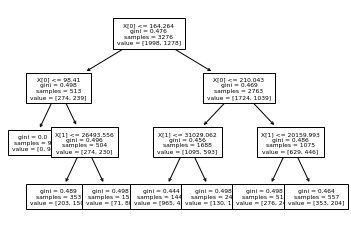

In [24]:
plot_tree(cltree1, fontsize = 6)

Again, we can either predict **class labels** or **class probabilities**.

In [25]:
# Class labels
# [hardness, solids]
cltree1.predict(np.array([[175, 15666],
                          [217, 15666],
                          [196, 22014],
                          [217, 22014]]))

# [0, 0, 0, 0] means all are predicated to be non-potable

array([0, 0, 0, 0], dtype=int64)

In [26]:
# Class probabilities

cltree1.predict_proba(np.array([[175, 15666],
                          [217, 15666],
                          [196, 22014],
                          [217, 22014]]))

# [P(Y=0), P(Y=1)]

array([[0.66782007, 0.33217993],
       [0.53281853, 0.46718147],
       [0.66782007, 0.33217993],
       [0.63375224, 0.36624776]])

Sometimes we want to fit a tree, but it ends up being overfitted. We can **prune** trees in a few ways, ncluding cost-complexity pruning or cross-validation. We can also control the minimum number of samples that a leaf can have (`min_sample_leaf`), among other things.

The best combination can be determined using cross-validation. We can also

1. Set up the values to consider
2. Use `GridSearchCV()` to return the best values

In [27]:
# Set up a dictionary that corresponds to our tuning parameters
parameters = {'max_depth': range(2,15),
              'min_samples_leaf': [10, 50, 100]}

In [39]:
# Import the grid search function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

tuning_model = GridSearchCV(DecisionTreeClassifier(), # the model to use
                            parameters,               # combination of parameters to use
                            cv=5, 
                            scoring='accuracy')

In [40]:
# Now fit the model
tuning_model.fit(X = water[['Hardness', 'Solids', 'Chloramines', 'Organic_carbon']].values,
                 y = water['Potability'].values)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 15),
                         'min_samples_leaf': [10, 50, 100]},
             scoring='accuracy')

In [41]:
# Inspect the best combination of tuning parameters
# from the dictionary that we created
tuning_model.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)

In [42]:
# best_score_ is accuracy for the "best" model
print(tuning_model.best_score_, tuning_model.best_params_)

0.6068343883820517 {'max_depth': 4, 'min_samples_leaf': 10}


[Text(0.45689655172413796, 0.9, 'X[0] <= 164.264\ngini = 0.476\nsamples = 3276\nvalue = [1998, 1278]'),
 Text(0.1896551724137931, 0.7, 'X[2] <= 8.337\ngini = 0.498\nsamples = 513\nvalue = [274, 239]'),
 Text(0.06896551724137931, 0.5, 'X[2] <= 3.689\ngini = 0.489\nsamples = 383\nvalue = [220, 163]'),
 Text(0.034482758620689655, 0.3, 'gini = 0.375\nsamples = 16\nvalue = [4, 12]'),
 Text(0.10344827586206896, 0.3, 'X[1] <= 16282.218\ngini = 0.484\nsamples = 367\nvalue = [216, 151]'),
 Text(0.06896551724137931, 0.1, 'gini = 0.5\nsamples = 92\nvalue = [45, 47]'),
 Text(0.13793103448275862, 0.1, 'gini = 0.47\nsamples = 275\nvalue = [171, 104]'),
 Text(0.3103448275862069, 0.5, 'X[3] <= 11.754\ngini = 0.486\nsamples = 130\nvalue = [54, 76]'),
 Text(0.2413793103448276, 0.3, 'X[1] <= 12970.312\ngini = 0.457\nsamples = 34\nvalue = [22, 12]'),
 Text(0.20689655172413793, 0.1, 'gini = 0.298\nsamples = 11\nvalue = [9, 2]'),
 Text(0.27586206896551724, 0.1, 'gini = 0.491\nsamples = 23\nvalue = [13, 10]'

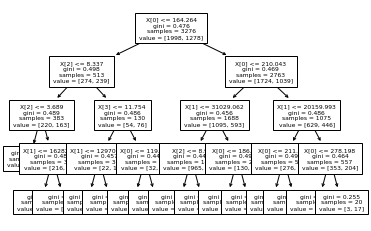

In [43]:
plot_tree(tuning_model.best_estimator_, fontsize=6)

Accuracy is not the only loss function, and we may see **log-loss** used instead. To find log-los, we just change `scoring='accuracy'` to `scoring='neg_log_loss'`.

In [44]:
tuning_model2 = GridSearchCV(DecisionTreeClassifier(),
                            parameters,
                            cv = 5,
                            scoring='neg_log_loss')

tuning_model2.fit(water[['Hardness', 'Solids', 'Chloramines', 'Organic_carbon', 'Turbidity']].values,
                  water['Potability'].values)

tuning_model2.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=100)

In [45]:
print(tuning_model2.best_score_, tuning_model2.best_params_)

-0.6743150518917174 {'max_depth': 2, 'min_samples_leaf': 100}


### Ensemble trees

Trees are highly variable. Two different data sets from the same population can yield very different trees. Bagging and random forests allow us to fit many trees to a data set and average across the predictions from those trees to improve our loss function (and our prediction). 

- A single tree has little bias but high variability
- Averaging across many trees reduces variation 

How do we get multiple trees from one data set? We use **bootstrapping**. We lose interpretability, but we can look at variance and other important measures and identify the most important variables for our trees. 

We call these **ensemble tree methods** because we're bringing in many trees (an ensemble). Three ensemble methods are 

1. Bagging (bootstrap aggregation) - this is the simplest
2. Random forests (just like bagging, wbut we randomly select bpredictors)
3. Boosting (slow training of trees, great prediction performance)

#### Bagging - "bootstrap aggregation"

Bootstrapping is resamplng from our data to get "new" samples. Resampling from the data itself is called **non-parametric bootstrapping**. We can also fit a model and generate values form this model **parametric bootstrapping**).  

Non-parametric bootstrapping 

- treats our sample as the population (_n_ = # of observations)
- resampling is done with replacement - grab _n_ things from our population with replacement
- we can get the same observation multiple times, but we fit a tree to a slightly different set of observations each time

##### Bagging with regression trees

1. Create a bootstrap sample (must be the same size as the actual sample)
    - `sample(data, size=n, replace=True` where `data` is the observed data
2. Take our sample and train the tree on this sample (no pruning necessary, just fit a large tree)
    - call the prediction for a given set of _x_ values $\hat{y}^{*1}(x)$
3. Repeat this B=1000 total times
4. Final prediction is the average of these predictions
    - $\hat{y}(x) = \frac{1}{B}\sum_{j=1}^{B}\hat{y}^{*1}(x)$

##### Bagging with classification trees

1. Create a bootstrap sample (must be the same size as the actual sample)
    - `sample(data, size=n, replace=True` where `data` is the observed data
2. Take our sample and train the tree on this sample (no pruning necessary, just fit a large tree)
    - call the prediction for a given set of _x_ values $\hat{y}^{*1}(x)$
3. Repeat this B=1,000 total times, getting 1,000 different predictions
    - obtain $\hat{y}^{*j}(x), j=1, \ldots, B$
4. (One option) Use **majority vote** as the final classification prediction (i.e. use the most common prediction made by all bootstrap trees)

##### Bagging example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
bike_data = pd.read_csv('bikeDetails.csv')

# create response and new predictor
bike_data['log_selling_price'] = np.log(bike_data['selling_price'])
bike_data['log_km_driven'] = np.log(bike_data['km_driven'])

Since bagging is just a special case of random forest, we can do bagging by using the `RandomForestRegressor` function with `max_features` set to `None`. There are really no tuning parameters - the default says to train on 100 trees (bootstrap samples), but usually 1,000 is better.

In [3]:
from sklearn.ensemble import RandomForestRegressor
bag_tree = RandomForestRegressor(max_features=None, n_estimators=500)
bag_tree.fit(bike_data[['log_km_driven', 'year']].values,
            bike_data['log_selling_price'])

RandomForestRegressor(max_features=None, n_estimators=500)

In [4]:
# Now we can use .predict()
print(bag_tree.predict(np.array([[9.5,1990], [9.5,2015], [10.6, 1990], [10.6, 2015]])))

[10.72531322 10.81416229  9.78386698 10.4323285 ]


In [6]:
print(np.exp(bag_tree.predict(np.array([[9.5,1990], [9.5,2015], [10.6, 1990], [10.6, 2015]]))))

[45492.97591512 49719.98737772 17745.14039482 33939.2860256 ]


In [7]:
bag_tree.feature_importances_

array([0.42296543, 0.57703457])

Text(0.5, 0, 'Importance')

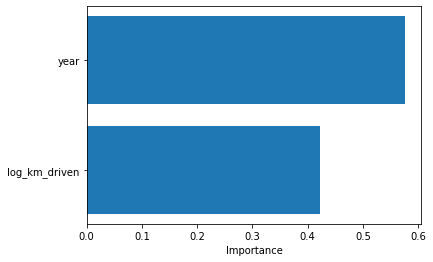

In [9]:
plt.barh(bike_data.columns[[8,2]], bag_tree.feature_importances_)
plt.xlabel("Importance")

In [10]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

bag_cv = cross_validate(RandomForestRegressor(max_features = None, n_estimators = 500),
                        bike_data[['log_km_driven', 'year']].values,
                        bike_data['log_selling_price'], cv = 5, scoring = "neg_mean_squared_error")

# Regression tree
rtree_tune = GridSearchCV(DecisionTreeRegressor(),
                            {'max_depth': range(2,15),'min_samples_leaf':[10, 50, 100]}, cv = 5,
                            scoring = "neg_mean_squared_error") \
                            .fit(bike_data[['log_km_driven', 'year']].values,
                                        bike_data['log_selling_price'])

# Cross-validate
rtree_cv = cross_validate(rtree_tune.best_estimator_,
                        bike_data[['log_km_driven', 'year']].values,
                        bike_data['log_selling_price'], cv = 5, scoring = "neg_mean_squared_error")

mlr_cv = cross_validate(LinearRegression(),
                        bike_data[['log_km_driven', 'year']].values,
                        bike_data['log_selling_price'], cv = 5, scoring = "neg_mean_squared_error")

# RMSE values
print(np.sqrt(-sum(bag_cv['test_score'])), np.sqrt(-sum(rtree_cv['test_score'])),
      np.sqrt(-sum(mlr_cv['test_score'])))

1.267664018545775 1.1532081197228359 1.1582865568323069


#### Random forests

Random forests use the same idea as bagging, but we don't use all predictors in each tree. Instead, we only use a random subset of predictors for each bootstrap sample/tree fit. 

Why? If we have a very strong predictor in our data set, every first split will split on that best variable. This makes bagged trees more correlated to one another. But using a random subset of predictors, we get less correlated trees, which in turn reduces variance.

How many predictors should we choose? We have rules of thumb:

- For classification
    - $\sqrt{\# predictors}$ 
- For regression
    - `num_features=# predictors/3`
    
If `num_features` = number of predictors, then we have bagging!

Also, it's best to determine `num_features` via cross-validation.

In [11]:
# Set up parameters
parameters = {"max_features": range(1,3)}

rf_tune = GridSearchCV(RandomForestRegressor(n_estimators = 500),
                       parameters, cv = 5, scoring = "neg_mean_squared_error")

# Consider 2 variables as predictors
rf_tune.fit(bike_data[['log_km_driven', 'year']].values,
            bike_data['log_selling_price'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_estimators=500),
             param_grid={'max_features': range(1, 3)},
             scoring='neg_mean_squared_error')

In [12]:
print(rf_tune.best_estimator_)

RandomForestRegressor(max_features=1, n_estimators=500)


In [14]:
rf_tune.best_estimator_.fit(bike_data[['log_km_driven', 'year']].values,
                            bike_data['log_selling_price']).feature_importances_

array([0.54967891, 0.45032109])

In [16]:
# Compare all model CV errors
rf_cv = cross_validate(rf_tune.best_estimator_,
                         bike_data[['log_km_driven', 'year']].values,
                         bike_data['log_selling_price'], cv = 5,
                         scoring = "neg_mean_squared_error")

print(np.sqrt(-sum(rf_cv['test_score'])), np.sqrt(-sum(bag_cv['test_score'])),
      np.sqrt(-sum(rtree_cv['test_score'])), np.sqrt(-sum(mlr_cv['test_score'])))

1.2522171765983006 1.267664018545775 1.1532081197228359 1.1582865568323069
